## Decision Tree: Branch Analyses

1. Reporting Year (Year 0 - baseline)
2. TTC Tree cover
3. Land Use
4. Strategy
5. Imagery or site accessibility

### Decisions
- An "open" or "closed" designation was assigned at the project level based on the proportion of sites that fell the into open/closed category.
- Project names that did not align were dropped.
- ttc NA - sites without TTC % were dropped. This occurs due to missing TTC tiles, eventually we will have data. 
- Sites where planting occurs in 2025 were dropped. TODO: Check the other sites in the prj.
- What does imagery % represent and what is a workable threshold? Does it represent coverage for the polygon or wider AOI?
- plant_start - date that planting is started is available by site, so would have to aggregate for a project. Does it make sense to do the first date of planting?
- when merging ttc and ft_polys using 3 keys - project name, site name and polygon name - there are some duplicates. It seems all values are the same except the slope and aspect stats. Not using these columns for now so dropping.

**Notes on datasets**
- `target_sys` in ttc refers to the current land use (used for error calcs)
- Can I assume that any LU that is not in 'direct_seeding', 'tree_planting', 'assisted_natural_regeneration', is a type of ANR?

**Questions**
- Rhiannon - how did she define plant start date

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from os import listdir

# Polygon

## Align/clean datasets

In [89]:
ttc_raw = pd.read_excel('../data/ttc_baseline_062024.xlsx')
ft_prj = pd.read_csv('../data/features_project_071824.csv')
ft_poly = pd.read_csv('../data/features_polygon_071824.csv')

# drop 'herp-ghana'
ft_names = sorted(ft_prj.Project.unique())
ttc_names = sorted(ttc_raw.Project.unique())
no_match = [i for i in ttc_names if i not in ft_names] 
ttc_raw = ttc_raw.drop(ttc_raw[ttc_raw.Project == no_match[0]].index) 

ft_poly_names = sorted(ft_poly.poly_name.unique())
ttc_poly_names = sorted(ttc_raw.poly_name.unique())
match = [i for i in ttc_poly_names if i in ft_poly_names]

print("Total Projects")
print(len(ttc_raw.Project.unique()))
print(len(ft_prj.Project.unique()))
print(len(ft_poly.Project.unique()))
print("Total Polygons")
print(len(ft_poly_names))
print(len(ttc_poly_names))
print(f"Matching: {len(match)}")

Total Projects
75
75
75
Total Polygons
11429
11191
Matching: 10990


In [90]:
ft_poly.columns = ft_poly.columns.map(lambda x: re.sub(' ', '_', x.lower().strip()))

In [91]:
def clean_ttc(ttc_raw):
    to_keep = ['Percent Tree Cover 2020', 'Project', 'SiteName', 'poly_name']
    drop_cols = [col for col in ttc_raw.columns if col not in to_keep]
    ttc = ttc_raw[to_keep]
    ttc.columns = ttc.columns.map(lambda x: re.sub(' ', '_', x.lower().strip()))
    ttc = ttc.rename(columns={'percent_tree_cover_2020': 'ttc'})
    print(f"Dropping {len(ttc[ttc['ttc'] == 'TTC_NA'])} null values for TTC")
    ttc = ttc[ttc['ttc'] != 'TTC_NA']
    ttc['ttc'] = ttc['ttc'].astype('float')
    ttc['ttc'] = ttc['ttc'].round()
    print(ttc['ttc'].min(), ttc['ttc'].max())
    return ttc

ttc = clean_ttc(ttc_raw)

Dropping 221 null values for TTC
0.0 100.0


In [92]:
columns_to_match = ['project', 'sitename', 'poly_name']
dups = ft_poly.duplicated(subset=columns_to_match, keep=False)
dups_total = dups.sum()
dups_total

2032

In [95]:
ft_poly = ft_poly.drop_duplicates(subset=columns_to_match)

In [98]:
inter = pd.merge(ft_poly, ttc, on=columns_to_match)

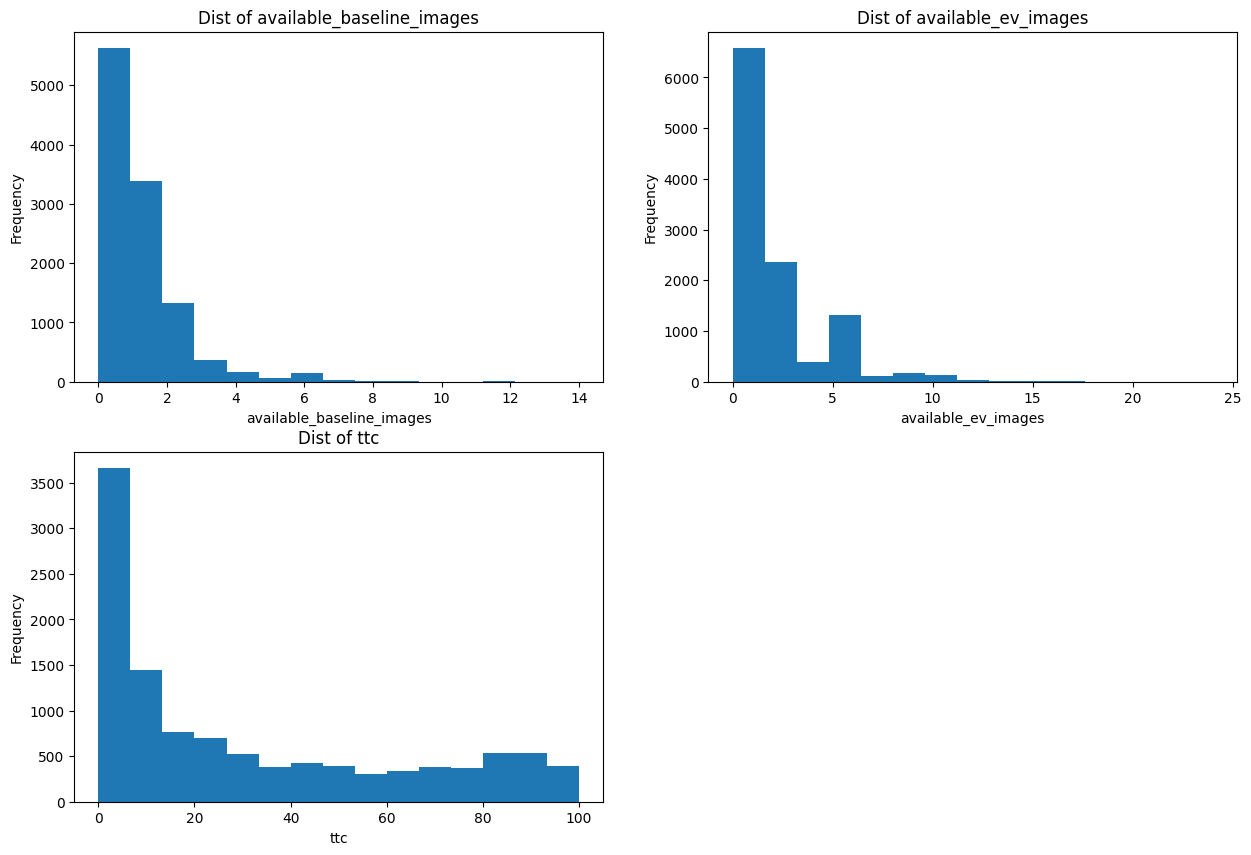

In [120]:
columns = ['available_baseline_images', 
          'available_ev_images',
          'ttc']
num_plots = len(columns)
fig, axes = plt.subplots(2, (num_plots // 2 + num_plots % 2), figsize=(15, 10))
axes = axes.flatten()
for i, col in enumerate(columns):
    inter[col].plot(kind='hist', bins=15, ax=axes[i], title=f'Dist of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
# Remove any empty subplots
for j in range(len(columns), len(axes)):
    fig.delaxes(axes[j])

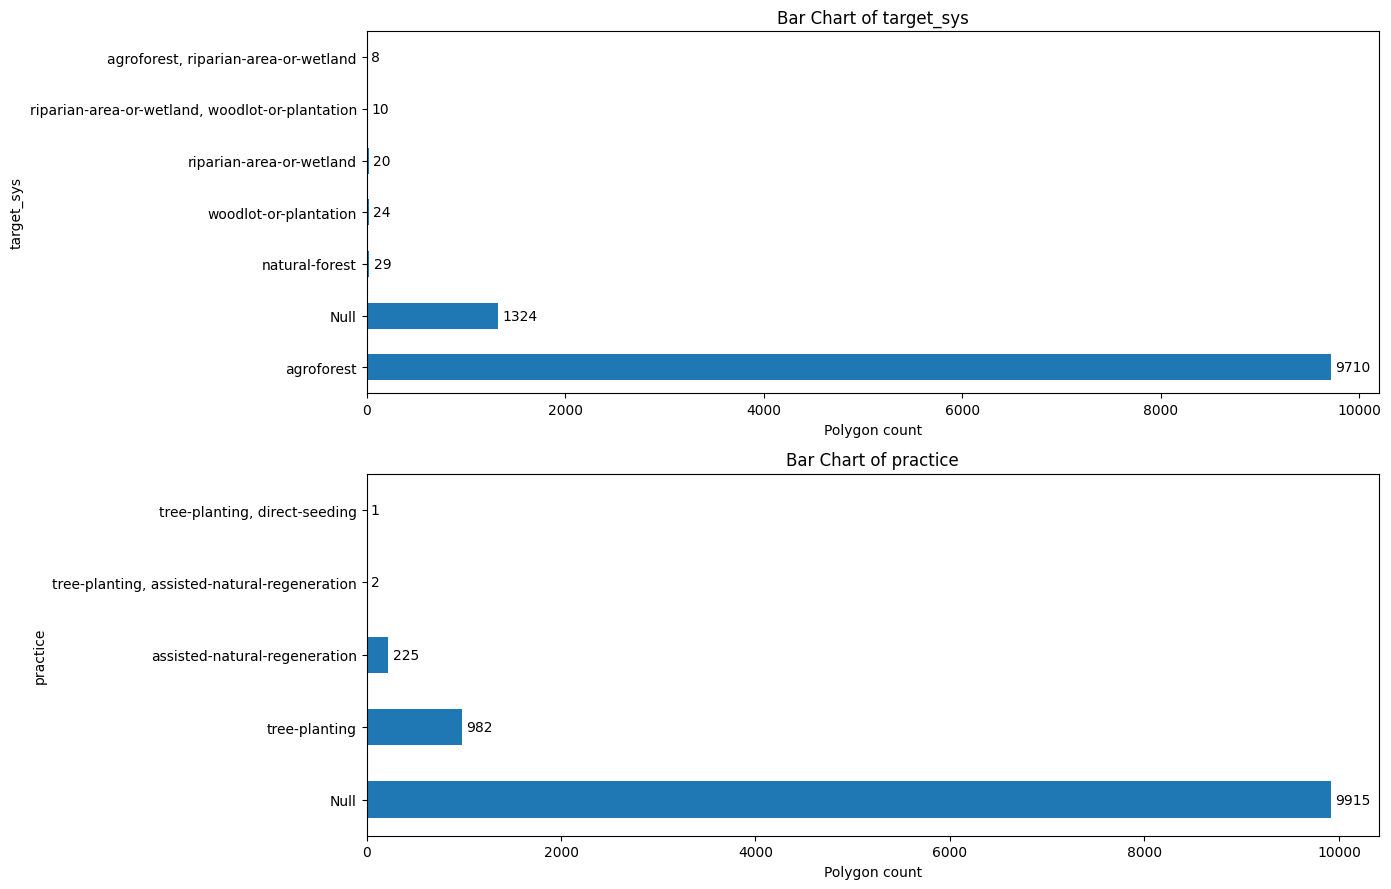

In [163]:
columns = ['target_sys', 'practice']
num_plots = len(columns)
fig, axes = plt.subplots(2, (num_plots // 2 + num_plots % 2), figsize=(14,9))
axes = axes.flatten()
for i, col in enumerate(columns):
    inter[col].value_counts().plot(kind='barh', ax=axes[i], title=f'Bar Chart of {col}')
    axes[i].set_xlabel('Polygon count')
    axes[i].set_ylabel(col)
    for bars in axes[i].containers:
        axes[i].bar_label(bars,
                          label_type='edge', 
                          padding=3)
        
# Remove any empty subplots
for j in range(len(columns), len(axes)):
    fig.delaxes(axes[j])
    

plt.tight_layout()

## Create Branches

In [164]:
def classify_canopy(project):
    closed_canopy = (project['ttc'] > 40).sum()
    open_canopy = (project['ttc'] <= 40).sum()
    return 'open' if open_canopy > closed_canopy else 'closed'

# .transform() method in pandas is used to apply a function to a group or subset of a df and 
# return an aligned result, meaning the output has the same shape as the input.
# ttc['canopy'] = ttc.groupby('project')['ttc'].transform(lambda x: classify_canopy(ttc[ttc['project'] == x.name]))

<class 'pandas.core.frame.DataFrame'>
Index: 11448 entries, 0 to 11448
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ttc        11448 non-null  float64
 1   project    11448 non-null  object 
 2   sitename   11448 non-null  object 
 3   poly_name  11448 non-null  object 
 4   canopy     11448 non-null  object 
dtypes: float64(1), object(4)
memory usage: 536.6+ KB


In [68]:
print(f"Total sites <=40% cover: {len(ttc[ttc.ttc <= 40])}")
print(f"Total sites >40% cover: {len(ttc[ttc.ttc > 40])}")

Total sites <=40% cover: 7808
Total sites >40% cover: 3641


In [69]:
ttc.canopy.value_counts()

canopy
open      8552
closed    2897
Name: count, dtype: int64

### Legacy Code

In [85]:
# create a master csv of all projects for img availability, elevation and sun
img_dir = 'imagery_availability/cohort1/'
csv_list = listdir(img_dir)
csv_list = [re.split(r'_', file)[1] for file in csv_list if file.endswith('.csv')]
master_csv = pd.DataFrame()
for i in csv_list[0:1]:
    i = 'bccp'
    df = pd.read_csv(f'{img_dir}afr100_{i}_imagery_availability.csv')
    df = df[['id', 
             'collection', 
             'properties.datetime',
             'properties.eo:cloud_cover',
             'properties.collect_time_end',
             'properties.collect_time_start',
#              'properties.off_nadir_avg', 
#              'properties.off_nadir_end',
#              'properties.off_nadir_max', 
#              'properties.off_nadir_min',
#              'properties.view:sun_elevation_max',
#              'properties.view:sun_elevation_min',
            ]]
    dt_cols = ['properties.datetime',
                 'properties.collect_time_end',
                 'properties.collect_time_start',
               ]
    df[dt_cols] = df[dt_cols].apply(pd.to_datetime, errors='coerce')
    # Ensure 'properties.datetime' column is timezone-naive
    df['properties.datetime'] = df['properties.datetime'].apply(lambda x: x.replace(tzinfo=None) if x.tzinfo else x)
    planting_date = ttc[ttc.project == i]['plantstart']
#    df['baseline_imgs'] = df['properties.datetime'].apply(lambda x: 1 if planting_date <= x <= planting_date + timedelta(days=365) else 0)
#     df['baseline_cloud_free'] = len(df[(df['baseline_imgs'] == 1) & (df['properties.eo:cloud_cover'] == 1)])
#     agg_data = {
#         'project_name': i,
#         'total_imgs': len(df),
#         'total_cloud_free': sum(df['properties.eo:cloud_cover']),
#         'baseline_imgs': sum(df['baseline_imgs']),
#         'baseline_cloud_free':sum(df['baseline_cloud_free']),
#                              }
# #         'early_imgs':,
# #         'early_cloud_free',
# #         'endline_imgs':,
# #         'endline_cloud_free':,
#     agg_table = pd.DataFrame([agg_data])
    

In [15]:
ft_raw.columns = ft_raw.columns.map(lambda x: re.sub(' ', '_', x.lower().strip()))
ft = ft_raw[['project', 'area_ha', 'percent_imagery_coverage', 'agroforestry',
       'tree_planting', 'assisted_natural_regeneration', 'enrichment_planting',
       'reforestation', 'direct_propagules_planting', 'natural_regeneration',
       'applied_nucleation/tree_island', 'woodlot', 'direct_seeding',
       'mangrove_tree_restoration', 'natural_forest', 'riparian_restoration']]
ft = ft.rename(columns={'mangrove_tree_restoration': 'mangrove',
                    'riparian_restoration':'riparian'})

## land use
land_use = ['agroforestry',
            'woodlot',
            'mangrove', 
            'natural_forest', 
            'riparian']

for col in land_use:
    ft[col] = ft[col].apply(lambda x: 1 if x > 0 else x)

## planting strategy
strategy = ['direct_seeding', 
            'tree_planting', 
            'assisted_natural_regeneration', 
            'natural_regeneration', # change this
            'enrichment_planting',
            'direct_propagules_planting',
            'applied_nucleation/tree_island',
            'reforestation',
           ]

for col in strategy:
    ft[col] = ft[col].apply(lambda x: 1 if x > 0 else x)